# Gaussian Regression Colors

This notebook uses Gaussian regression to fit CSP light curves and model the evolution of observed color over time. Results are compared to the color evolution of various supernova models.

#### Analysis steps considered by this notebook:

1. Read in and format data
1. Inspect the transmission curves of each CSP filter
1. Inspect the modeled color evolution
1. Fit observed light curves using a Gaussian regression
1. Compare the regressed color evolution against each model
1. Calculate chi-squared results


In [1]:
import sys
from copy import deepcopy
from pathlib import Path

import numpy as np
import sncosmo
from astropy.table import Table
from matplotlib import pyplot as plt
from sndata.csp import dr3

sys.path.insert(0, '../')
from analysis import models
from analysis import lc_colors


We begin by reading in photometric data from an arbitrarily chosen supernova. To compare each model against the observed light curve, the data and models need to share a common time axis. We accomplish this by using the CSP published `t0` value to shift the observed time axis so that `t=0` corresponds with the time of peak flux in the B-band. A similar shift is applied to each of the models; however, that logic is wrapped in the various plotting functions we define later on. We also add a custom extinction component to each model using the Fitzpatrick 99 extinction law.

In [2]:
# Register models and data with sncosmo
models.register_sources(force=True)
dr3.download_module_data()
dr3.register_filters(force=True)

# Pick a CSP target to use in demo plots
demo_id = '2005kc'
demo_data = dr3.get_data_for_id(demo_id, format_sncosmo=True)
demo_data['time'] -= lc_colors.get_csp_t0(demo_id)

# Load various SN models
m102 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.02))
m104 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.04))
m14 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.4))
m17 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.7))
salt2 = sncosmo.Model(sncosmo.get_source('salt2', version='2.4'))

# Add an extinction component to each model
# The extinction component is zero until changed
model_list = [m102, m104, m14, m17, salt2]
for model in model_list:
    model.add_effect(sncosmo.F99Dust(), 'ext', 'rest')


## Transmission Filters

We review the CSP filter transmission curves and take note that there are multiple "duplicate" filters. This is due to observations being performed on multiple telescopes or, in the case of V band, a filter being broken and subsequently replaced.

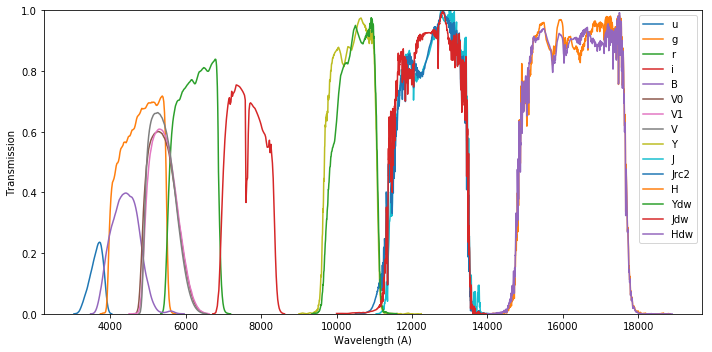

In [3]:
plt.figure(figsize=(10, 5))
for band_name in dr3.band_names:
    band = sncosmo.get_bandpass(band_name)
    band_label = band_name.split('_')[-1]
    
    plt.plot(band.wave, band.trans, label=band_label)
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Transmission')

plt.legend()  
plt.ylim(0, 1)
plt.tight_layout()


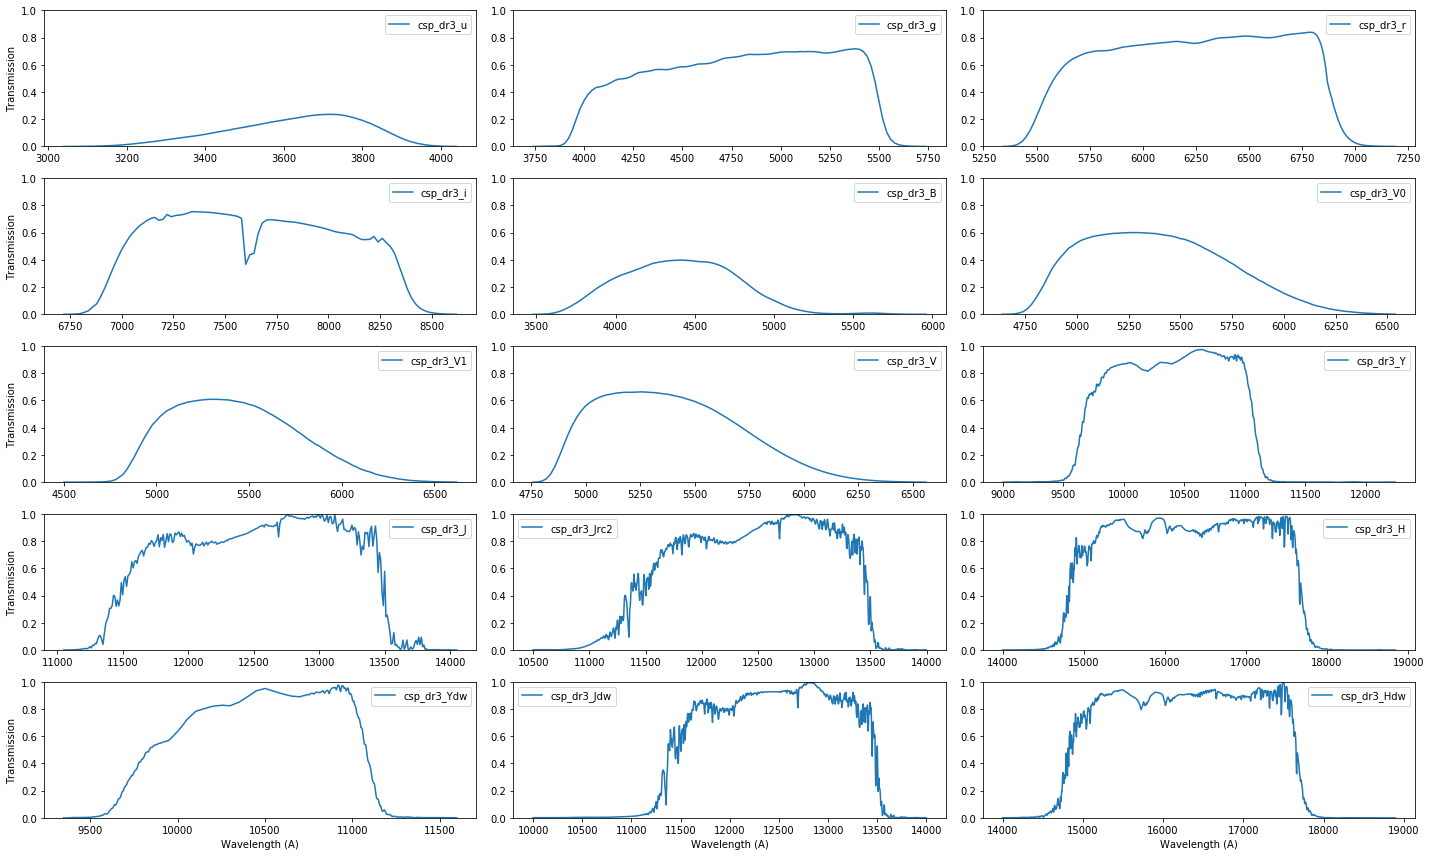

In [4]:
columns = 3
scale_factor = 4

rows = int(np.ceil(len(dr3.band_names) / columns))
fig_shape = (rows, columns)
fig_size = (scale_factor * rows, scale_factor * columns)

fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
for band_name, axis in zip(dr3.band_names, axes.flatten()):
    band = sncosmo.get_bandpass(band_name)
    axis.plot(band.wave, band.trans, label=band_name)
    axis.set_ylim(0, 1)
    axis.legend()
    
for axis in axes[4, :]:
    axis.set_xlabel('Wavelength (A)')

for axis in axes[:, 0]:
    axis.set_ylabel('Transmission')
    
plt.tight_layout()


For simplicity, we define a set of fiducial band passes with unique effective wavelengths.

In [5]:
unique_bands = np.array([
    'csp_dr3_u',
    'csp_dr3_g',
    'csp_dr3_r',
    'csp_dr3_i',
    'csp_dr3_B',
    'csp_dr3_V',
    'csp_dr3_Y',
    'csp_dr3_H',
    'csp_dr3_J'
])

color_combos = [(unique_bands[i], unique_bands[i + 1]) for i in range(len(unique_bands) - 1)]


## CMFGEN Color Evolution

To develop intuition, we compare of CMFGEN color evolution against Salt2.4. We recognize that the color evolution of Salt2 is dependent on the model parameters. However, we only concern ourselves with a fiducial model having the default parameters.


In [6]:
def legend_without_duplicate_labels(ax):
    """Add a legend to a figure axis that only has unique labels
    
    Args:
        ax (axis): A matplotlib axis
    """

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


def subplot_model_colors(model, band_combos, axes, **kwargs):
    """Plot model colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        model                  (Model): Model to calculate color with
        band_combos (list[tuple[str]]): Band combos to calculate color for
        axes                   (array): Use existing axes
        Any other style kwargs for pyplot.plot
    """

    axis_list = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    if len(axis_list) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    time = np.arange(model.mintime(), model.maxtime())
    t0 = model.source.peakphase('csp_dr3_G')
    for (band1, band2), axis in zip(band_combos, axis_list):
        try:
            c = model.color(band1, band2, 'ab', time)
            
        except ValueError as e:
            print(f'{model.source.name} {model.source.version}: {e}')
            pass

        else:
            label = f'{model.source.name} {model.source.version}'
            axis.plot(time - t0, c, label=label, **kwargs)
            
            y_label = f'{band1.split("_")[-1]} - {band2.split("_")[-1]}'
            axis.set_ylabel(y_label)
            axis.set_xlabel('Time')
            legend_without_duplicate_labels(axis)


def plot_model_colors(models, bands):
    """Plot model colors for a given collection of models and bandpasses
    
    Args:
        models (list[Model]): Models to calculate color with
        bands    (list[str]): Bands to calculate color for
    
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    band_combos = [(bands[i], bands[i + 1])for i in range(len(bands) - 1)]
    
    columns = 3
    rows = int(np.ceil(len(band_combos) / columns))
    fig_shape = (rows, columns)
    fig_size = (4 * rows, 4 * columns)
    
    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for model in models:
        subplot_model_colors(model, band_combos, axes)
        
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    # fig.legend(handles, labels)
    plt.tight_layout()
    return fig, axes


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2000, .., 9200]


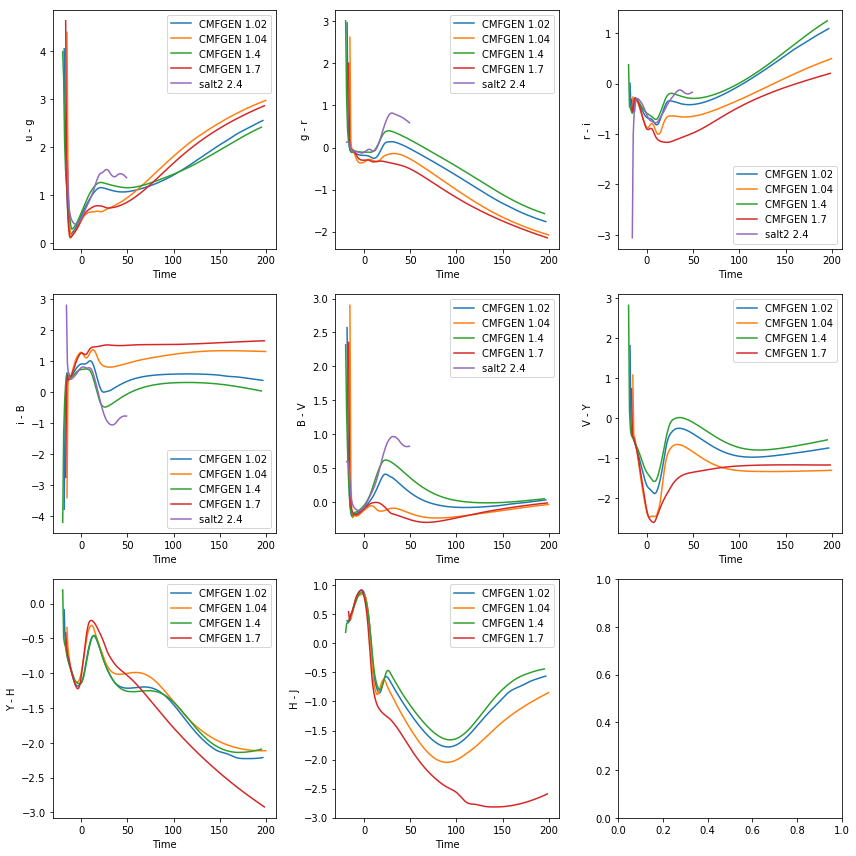

In [7]:
# Protect against chages that may 
# propogate from later in the notebook
for model in model_list: 
    model.set(extebv=0)

fig, axes = plot_model_colors(model_list, unique_bands)


# Gaussian Regression

We use Gaussian regression to fit the light curves in each band. These fits are then compared against a simultaneous fit performed using the Salt2 model.


In [8]:
def plot_regression(data, time, bands, pred_flux, pred_unc):
    """Plot regression results
    
    Args:
        data            (Table): The measured photometric data
        pred_flux (list[float]): Predicted flux from the regression
        pred_unc  (list[float]): Flux uncertainty from the regression
    
    Returns:
        The figure object
        An array of figure axes
    """

    columns = 2
    rows = 5
    fig_shape = (rows, columns)
    fig_size = (4 * rows, 8 * columns)

    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for axis in axes[rows - 1]:
        axis.set_xlabel('Time')
        
    for axis in axes.flatten()[::2]:
        axis.set_ylabel('Flux')
        
    plot_data = zip(bands, axes.flatten(), pred_flux, pred_unc)
    for band_name, axis, f, fe in plot_data:
        band_data = data[data['band'] == band_name]
        axis.scatter(band_data['time'], band_data['flux'], label=band_name)
        axis.errorbar(band_data['time'], band_data['flux'], band_data['fluxerr'], linestyle='', label=None)
        axis.plot(time, f, linestyle='--', color='black', label='Regression')
        axis.fill_between(
            time, 
            f - fe, 
            f + fe, 
            alpha=.3, 
            color='grey',
            label='Regression Error'
        )
        
        axis.set_xlim(min(time), max(time))
        axis.legend()

    plt.tight_layout()
    return fig, axes


def subplot_sncosmo_fit(time, bands, fitted_model, axes):
    """
    
    Args:
        fitted_model (Model): An SNCosmo model fitted to the data
        axes         (array): Use existing axes
    """

    for band, axis in zip(bands, axes.flatten()):
        try:
            band_flux = fitted_model.bandflux(band, time)
        
        except ValueError as e:
            print(f'{fitted_model.source.name} {fitted_model.source.version}: {e}')
            pass
        
        else:
            axis.plot(time, band_flux, label=f'{fitted_model.source.name}')
            axis.legend()


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2030.2, .., 9338.92]


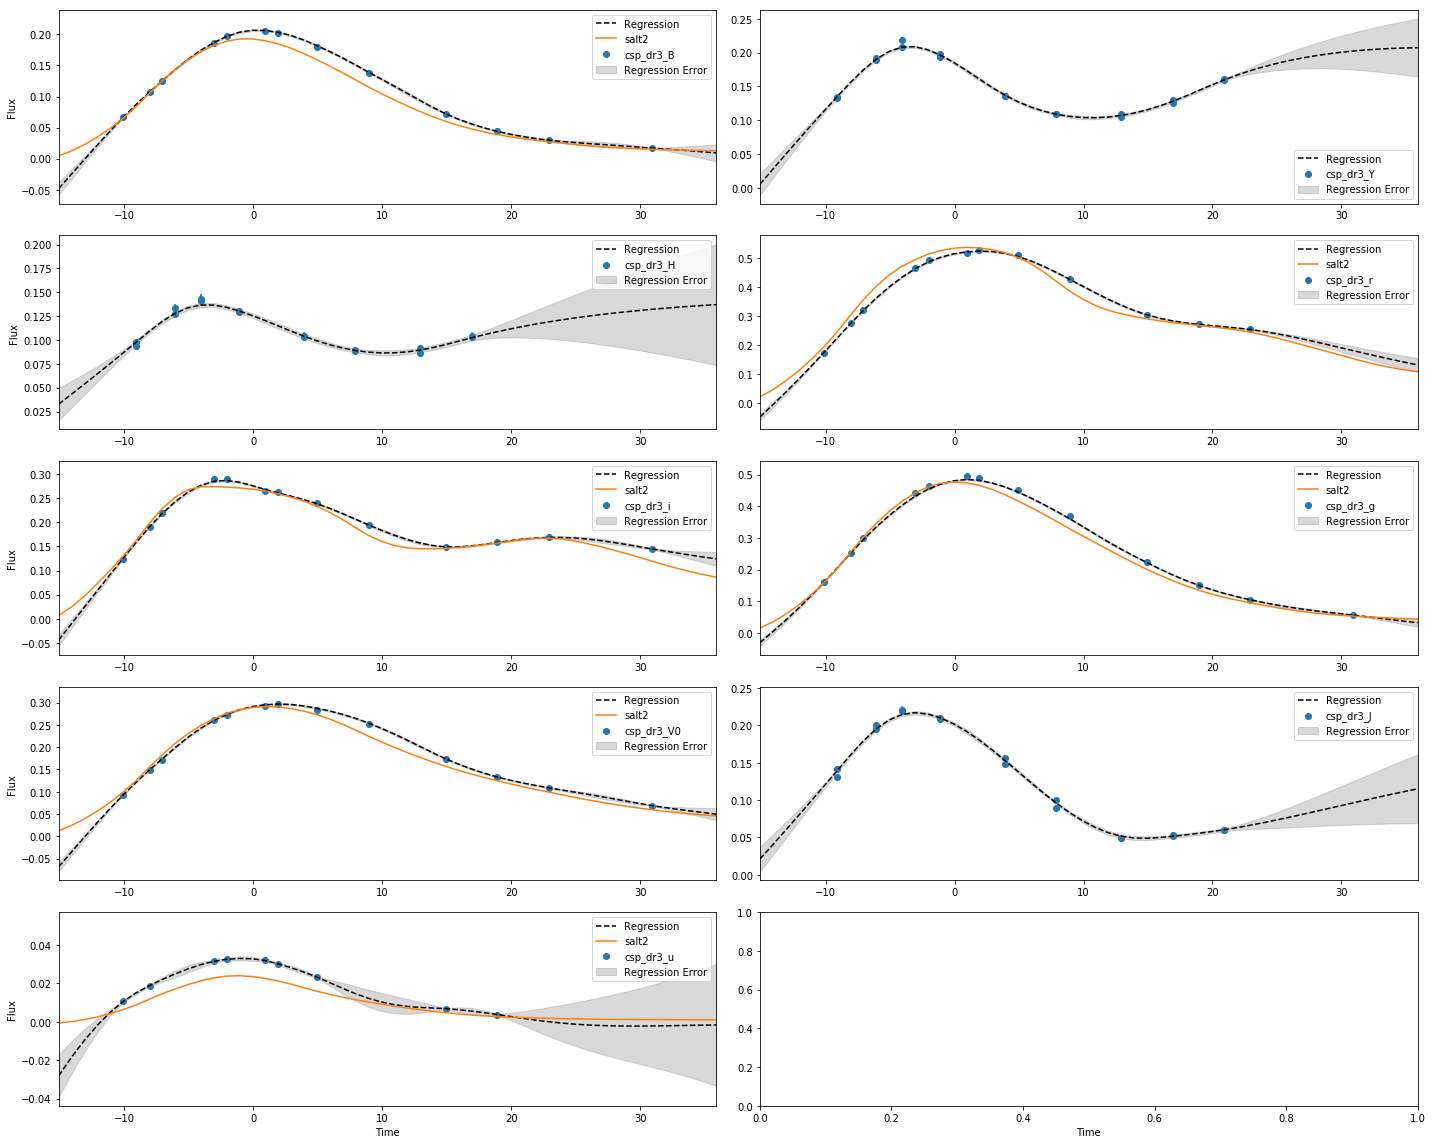

In [9]:
# Fit a gaussian regression
gp = lc_colors.fit_gaussian_process(demo_data)

# Fit salt2
salt2_model = deepcopy(salt2)
salt2_model.set(z=demo_data.meta['redshift'])
salt2_model.set(t0=0)
salt2_model.set(extebv=lc_colors.get_csp_ebv(demo_id))
fit_result, fitted_model = sncosmo.fit_lc(demo_data, salt2_model, ['x0', 'x1', 'c'])

# Plot modeled flux
bands = set(demo_data['band'])
time = np.arange(min(demo_data['time']) - 5, max(demo_data['time']) + 5)
pred_flux, pred_unc = lc_colors.predict_light_curve(gp, bands, time)
fig, axes = plot_regression(demo_data, time, bands, pred_flux, pred_unc)
subplot_sncosmo_fit(time, bands, fitted_model, axes)


Although the Gaussian regression performs well within the observed time range, Gaussian regressions are generally bad at extrapolating. For this reason, we choose to limit our use of the above regression when predicting flux and color values to within the first and last observed data point in each band.

## Comparing Gaussian and Modeled Colors

We compare the Gaussian fit color evolution against the CMFGEN models. 

In [10]:
def subplot_regression_color(data, band_combos, axes, **kwargs):
    """Plot regressed colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        gp            (GP): A fitted gaussian process
        t0         (float): Time of B max for the fitted target
        band_combos (list): List of tuples with two bandpass names
        axes       (array): Use existing axes
        Any other style kwargs for pyplot.plot
    """

    if len(axes.flatten()) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    gp = lc_colors.fit_gaussian_process(data)
    for (band1, band2), axis in zip(band_combos, axes.flatten()):
        try:
            tstart, tend = lc_colors.get_color_times(data, band1, band2)
        
        except ValueError:
            continue
        
        else:
            time = np.arange(tstart, tend)
            color = lc_colors.predict_color(gp, band1, band2, time)
            axis.plot(time, color, label='Regression', **kwargs)
            legend_without_duplicate_labels(axis)


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2030.2, .., 9338.92]


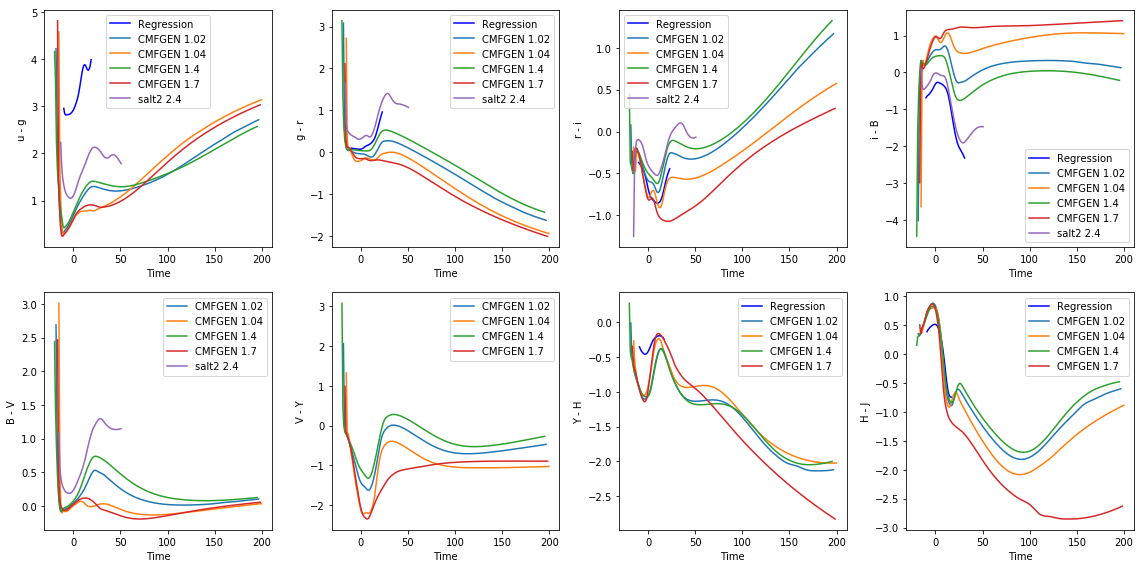

In [11]:
fig_shape = (2, 4)
fig_size = (16, 8)
fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
subplot_regression_color(demo_data, color_combos, axes, color='blue')

# Skip the unfit salt2 model
for model in model_list[:-1]: 
    model.set(extebv=lc_colors.get_csp_ebv(demo_id))
    subplot_model_colors(model, color_combos, axes)

# Plot the fitted salt2 model
subplot_model_colors(fitted_model, color_combos, axes)

axes[-1][-1].legend()
plt.tight_layout()


## $\chi^2$ Calculation

In [12]:
def subplot_fit_distributions(fit_results, axes, **kwargs):
    """Plot the distribution of fit residuals
    
    Args:
        fit_results (Table): A table generated by the lc_colors module
        axes        (array): Use existing axes
        Any other arguments for axis.hist
    """
    
    band_combos = fit_results[0].meta['bands']
    for (b1, b2), axis in zip(band_combos, axes.flatten()):
        column_name = f"{b1.replace('csp_dr3_', '')}_{b2.replace('csp_dr3_', '')}"
        plot_data = [table[column_name] for table in fit_results]
        labels = [f"{table.meta['source']} {table.meta['version']}" for table in fit_results]

        axis.hist(plot_data, **kwargs, label=labels)
        axis.set_title(column_name)
        axis.legend()


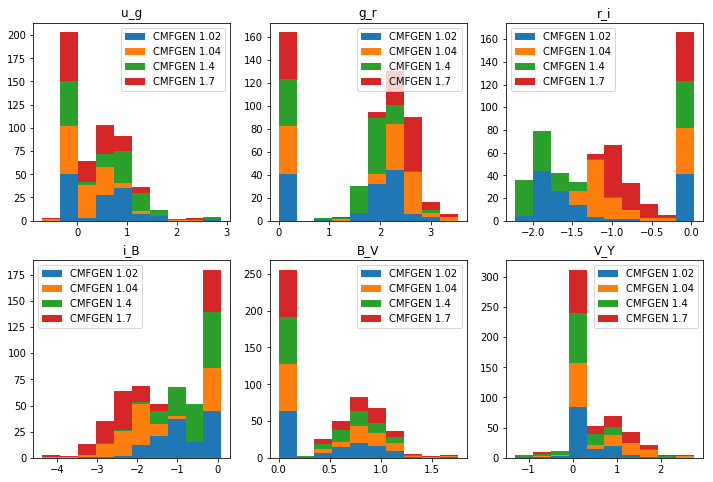

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
results_dir = Path('../results/color_evolution')
fit_results = [Table.read(results_dir / f'{model.source.name}_{model.source.version}.ecsv') for model in [m102, m104, m14, m17]]
subplot_fit_distributions(fit_results, axes, stacked=True, fill=True)

plt.show()
